In [174]:
import requests
from collections import defaultdict

import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d


import geopandas as gpd

from shapely.geometry import Point, Polygon

from bokeh.plotting import figure

In [191]:
df_textiel = pd.read_csv('../Data/Loopafstanden/afstand_textiel.csv', delimiter=';')

In [221]:
df_textiel['distance'].mean()

361.7487697591885

In [193]:
df_textiel['cluster_no'].unique().shape

(151954,)

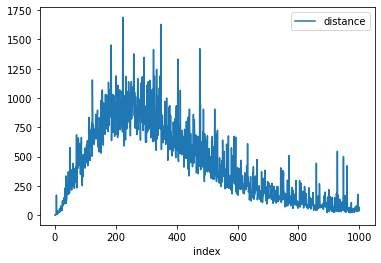

In [194]:
temp = df_textiel['distance'].astype('int').value_counts().reset_index().sort_values(by='index')
temp.plot(x='index', y='distance')

In [195]:
df_textiel['x'] = df_textiel['point_geom'].apply(lambda x: float(x.split(' ')[1].lstrip('(')))
df_textiel['y'] = df_textiel['point_geom'].apply(lambda x: float(x.split(' ')[2].rstrip(')')))
df1 = df_textiel.groupby('cluster_no').mean()
df2 = df_textiel.groupby('cluster_no').count()

In [196]:
df1['count'] = df2['fractie']
df1 = df1[['distance', 'x', 'y', 'count']].reset_index()
df1['points'] = df1.apply(lambda row: Point([row.x, row.y]), axis=1)

In [197]:
lst_points = []
for i in range(df1.shape[0]):
    for j in range(df1.iloc[i]['count'].astype('int')):
        lst_points.append(df1.iloc[j].points)

In [198]:
def load_data(pages = 725, save=False):
    """
    Loops through all pages of the API of garbage containers and stores these in a DF.
    The fraction and coordinates are saved with the unique id.
    """

    # Formation of variables to be filled in loop
    containers = []
    coordinates = []
    type_vuil = []
    counter = 0
    container_ids = []
    lons_new = []
    lats_new = []

    # Initial link to send GET request to
    link = 'https://api.data.amsterdam.nl/vsd/afvalcontainers'

    # While loop to get all pages
    while link != None and counter < pages: #100 as limit for testing purpose
        counter += 1 #Update counter
        response = requests.get(link) # Send request
        output = response.json()
        for result in output['results']:
            try:
                containers.append(result)
                container_ids.append(result['container_id'])
    #             lons_new.append(float(result['container_wgs84_lon']))
    #             lats_new.append(float(result['container_wgs84_lat']))
                lons_new.append(result['container_geometrie']['coordinates'][0])
                lats_new.append(result['container_geometrie']['coordinates'][1])
                type_vuil.append(result['container_afvalfractie'])
            except:
                print('a')
                pass 
        try:
            link = output['_links']['next']['href'] # Get link to next page

        except:
            link = None

    df= pd.DataFrame([container_ids, lons_new, lats_new, type_vuil]).T.rename(columns={0: 'id', 1:'x', 2:'y', 3:'fractie'})
    
    if save:
        df.to_csv('/../data/containers.csv')
    return df, containers

In [199]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def nn(x, y, pos, neg):
    v = np.array([[x, y]])
    p = np.sum(np.power(pos - v, 2), axis=1)
    n = np.sum(np.power(neg - v, 2), axis=1)
    return np.min(p) < np.min(n)

def plot_voronoi(multi, points, min_vals, max_vals, off=0.5):
    """
    Plots the given points as a voronoi diagram using min_vals and max_vals
    as boundaries for the plot.
    """
    fig = plt.figure(figsize=(16,12))
    axis = fig.add_subplot()
    polygons = []

    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    # Create map of Amsterdam
    for geom in multi:
        xs, ys = geom.exterior.xy
        axis.fill(xs, ys, alpha=0.2, fc='grey', ec='red')
        
    # Create map of inhabited parts of Amsterdam
    for geom in multi2:
        xs, ys = geom.exterior.xy
        axis.fill(xs, ys, alpha=0.2, fc='grey', ec='red')
    
    # Mark containers
    axis.plot(points[:, 0], points[:, 1], 'b+')
    
    # fill polygons with colour
    for region in regions:
        polygon = vertices[region]
        polygons.append(Polygon(polygon))
        axis.fill(*zip(*polygon), fc='none', ec='white', alpha=0.5)
            
    plt.xlim(min_vals[0]-off, max_vals[0]+off)
    plt.ylim(min_vals[1]-off, max_vals[1]+off)
    plt.title('Voronoi diagram of Textile container in Amsterdam')
    plt.show()
    return polygon

In [200]:
def create_voronoi_bokeh(containers, to_plot=True):
    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
    p = figure(tools= TOOLS, x_range=(110000, 135000), y_range=(475000, 495000), plot_width = 750, plot_height=600)
    
    vor = Voronoi(containers)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    polygons = []
    for region in regions:
        polygon = vertices[region]
        polygons.append(Polygon(polygon))
    
    if to_plot:
        street_map = gpd.read_file('../data/woonbc12_region.shp')
        street_map3 = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
        street_map3 = street_map3[street_map3['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
        geosource2 = GeoJSONDataSource(geojson = street_map.to_json())
        geosource3 = GeoJSONDataSource(geojson = street_map3.to_json())
        p.patches('xs', 'ys', source=geosource2, fill_color='whitesmoke', line_color='grey')
        p.patches('xs', 'ys', source=geosource3, fill_color='lightgray', line_color='grey')
        
        tmp = gpd.GeoDataFrame(polygons).rename(columns={0:'geometry'})
        geosource = GeoJSONDataSource(geojson = tmp.to_json())
        p.patches('xs', 'ys', source=geosource, fill_color='grey', line_color='black', alpha=0.2, line_width=0.1)
        p.circle(containers[:,0], containers[:,1], color='red', radius=6)
        show(p)
    return polygons

In [228]:
def assign_points_to_cell(polygons, containers, grid_points):
    dct = defaultdict(list)
    for point in grid_points:
        for i in range(len(polygons)):
            if polygons[i].contains(point):
                dct[str(containers[i])].append(point)
    return dct

def distribution_to_distance(tmp, grid_points):
    total = 0
    for k, v in tmp.items():
        container = k.lstrip('[').rstrip(']').split(' ')
        container = Point(float(container[0]), float(container[1]))
        for point in v:
            distance = point.distance(container)
            if distance > 750:
                print(distance)
            total += distance
#     print(total, total/len(grid_points))
    return total/len(grid_points)

In [203]:
# Load the dataframe and create 2d np-arrays of all fractions
df_containers, containers = load_data(pages=725)
df_containers = df_containers.dropna()
textiel = df_containers[df_containers['fractie'] == 'Textiel']
textiel = np.column_stack([textiel['x'], textiel['y']])
textiel = np.delete(textiel, 284, 0) #dont know why, but this makes it work
polygons_textiel = create_voronoi_bokeh(textiel, to_plot=False)

In [204]:
dct_assignments = assign_points_to_cell(polygons_textiel, textiel, lst_points)

In [229]:
distance_textiel = distribution_to_distance(dct_assignments, lst_points)

750.3848674618548
750.3848674618548
750.3848674618548
750.3848674618548
750.3848674618548
